In [1]:
# experiment 2

In [2]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 73.8 MB/s eta 0:00:00
Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 97% 276M/285M [00:00<00:00, 558MB/s]
100% 285M/285M [00:00<00:00, 611MB/s]


In [7]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [8]:
!pip install wandb onnx -Uq

# imports

In [9]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm

import wandb


In [10]:
torch.backends.cudnn.deterministic = True
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [11]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: konstantine25b (konstantine25b-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [12]:
run = wandb.init(
    entity="konstantine25b-free-university-of-tbilisi-",
    project="Facial_Expression_Recognition_2",
    config={
        "learning_rate": 0.001,
        "architecture": "Simpler CNN (2 conv layers + 2 FC layers)",
        "dataset": "Facial Expression Recognition Challenge",
        "epochs": 20,
        "batch_size": 32,
        "optimizer": "Adam",
        "loss_function": "Cross-Entropy Loss",
        "weight_decay": 1e-5,
        "dropout_rate": 0.3,
    },
)

# Data

In [13]:
# Load the original training data
original_train_df = pd.read_csv('train.csv')

# First split: Create a test set (10% of original data)
train_val_df, test_df = train_test_split(original_train_df, test_size=0.1,
                                         random_state=42, stratify=original_train_df['emotion'])

# Second split: Split remaining data into training (80%) and validation (20%)
train_df, val_df = train_test_split(train_val_df, test_size=0.2,
                                    random_state=42, stratify=train_val_df['emotion'])

# Define emotion labels
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
                  4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


In [14]:
print(f"Original data size: {len(original_train_df)}")
print(f"Training set size: {len(train_df)} ({len(train_df)/len(original_train_df)*100:.1f}%)")
print(f"Validation set size: {len(val_df)} ({len(val_df)/len(original_train_df)*100:.1f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(original_train_df)*100:.1f}%)")

# Print class distribution in each set
print("\nEmotion distribution:")
for i, emotion in emotion_labels.items():
    train_count = sum(train_df['emotion'] == i)
    val_count = sum(val_df['emotion'] == i)
    test_count = sum(test_df['emotion'] == i)
    print(f"  {emotion}: Train={train_count}, Val={val_count}, Test={test_count}")


Original data size: 28709
Training set size: 20670 (72.0%)
Validation set size: 5168 (18.0%)
Test set size: 2871 (10.0%)

Emotion distribution:
  Angry: Train=2877, Val=719, Test=399
  Disgust: Train=314, Val=78, Test=44
  Fear: Train=2950, Val=737, Test=410
  Happy: Train=5194, Val=1299, Test=722
  Sad: Train=3477, Val=870, Test=483
  Surprise: Train=2283, Val=571, Test=317
  Neutral: Train=3575, Val=894, Test=496


# model building

In [15]:
class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        pixels = [int(pixel) for pixel in row['pixels'].split()]
        image = np.array(pixels, dtype=np.uint8).reshape(48, 48)

        # Convert to PIL Image for transforms
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = row['emotion']
        return image, label

In [16]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Validation and test sets only need basic transformations
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets with appropriate transforms
train_dataset = FER2013Dataset(train_df, transform=train_transform)
val_dataset = FER2013Dataset(val_df, transform=val_test_transform)
test_dataset = FER2013Dataset(test_df, transform=val_test_transform)

overfit test

In [17]:
indices = list(range(20))
overfit_dataset = torch.utils.data.Subset(train_dataset, indices)
batch_size = wandb.config.batch_size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
overfit_loader = DataLoader(overfit_dataset, batch_size=batch_size, shuffle=True)

# Visualize some sample images
def pixels_to_image(pixels_str):
    pixels = [int(pixel) for pixel in pixels_str.split()]
    image = np.array(pixels).reshape(48, 48)
    return image

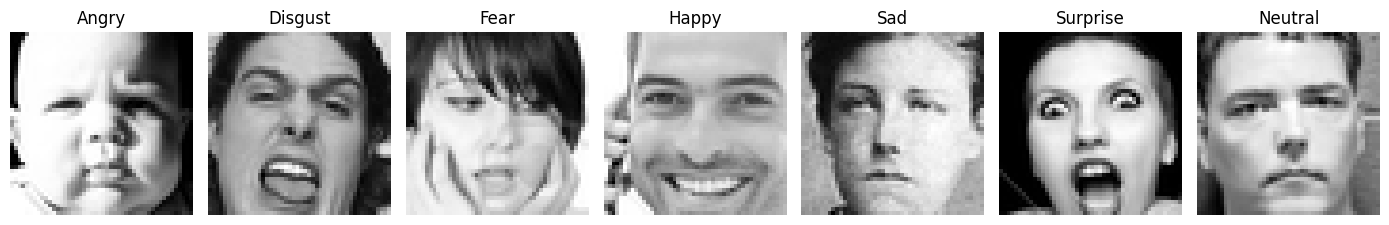

In [18]:
plt.figure(figsize=(14, 3))
for i, emotion in emotion_labels.items():
    sample = train_df[train_df['emotion'] == i].iloc[0]
    img = pixels_to_image(sample['pixels'])

    plt.subplot(1, 7, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

plt.tight_layout()
plt.savefig('emotion_samples.png')
plt.show()

# Log the examples to wandb
wandb.log({"emotion_samples": wandb.Image('emotion_samples.png')})


In [19]:
class SimplerCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(SimplerCNN, self).__init__()


        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)


        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)


        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):

        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [20]:
model = SimplerCNN(dropout_rate=wandb.config.dropout_rate).to(device)
print(model)

SimplerCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)


In [21]:
wandb.watch(model, log="all")

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=wandb.config.learning_rate,
    weight_decay=wandb.config.weight_decay
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [23]:
def compute_accuracy(loader, model, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels

In [24]:
print("Testing model on 20 samples to check for overfitting capability...")
epochs_overfit = 30
overfit_losses = []
overfit_accs = []

Testing model on 20 samples to check for overfitting capability...


In [25]:
for epoch in range(epochs_overfit):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in overfit_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    overfit_loss = running_loss / len(overfit_loader)
    overfit_acc = 100 * correct / total
    overfit_losses.append(overfit_loss)
    overfit_accs.append(overfit_acc)

    print(f"Overfit Epoch {epoch+1}/{epochs_overfit}, Loss: {overfit_loss:.4f}, Acc: {overfit_acc:.2f}%")


Overfit Epoch 1/30, Loss: 1.9559, Acc: 20.00%
Overfit Epoch 2/30, Loss: 1.6054, Acc: 55.00%
Overfit Epoch 3/30, Loss: 1.2086, Acc: 65.00%
Overfit Epoch 4/30, Loss: 1.0528, Acc: 65.00%
Overfit Epoch 5/30, Loss: 0.4625, Acc: 80.00%
Overfit Epoch 6/30, Loss: 0.7383, Acc: 80.00%
Overfit Epoch 7/30, Loss: 0.6909, Acc: 85.00%
Overfit Epoch 8/30, Loss: 0.5316, Acc: 85.00%
Overfit Epoch 9/30, Loss: 0.2299, Acc: 95.00%
Overfit Epoch 10/30, Loss: 0.2790, Acc: 95.00%
Overfit Epoch 11/30, Loss: 0.5468, Acc: 90.00%
Overfit Epoch 12/30, Loss: 0.0992, Acc: 95.00%
Overfit Epoch 13/30, Loss: 0.0208, Acc: 100.00%
Overfit Epoch 14/30, Loss: 0.0684, Acc: 95.00%
Overfit Epoch 15/30, Loss: 0.0322, Acc: 100.00%
Overfit Epoch 16/30, Loss: 0.0865, Acc: 95.00%
Overfit Epoch 17/30, Loss: 0.1603, Acc: 95.00%
Overfit Epoch 18/30, Loss: 0.0681, Acc: 95.00%
Overfit Epoch 19/30, Loss: 0.0386, Acc: 100.00%
Overfit Epoch 20/30, Loss: 0.0051, Acc: 100.00%
Overfit Epoch 21/30, Loss: 0.0055, Acc: 100.00%
Overfit Epoch 22/

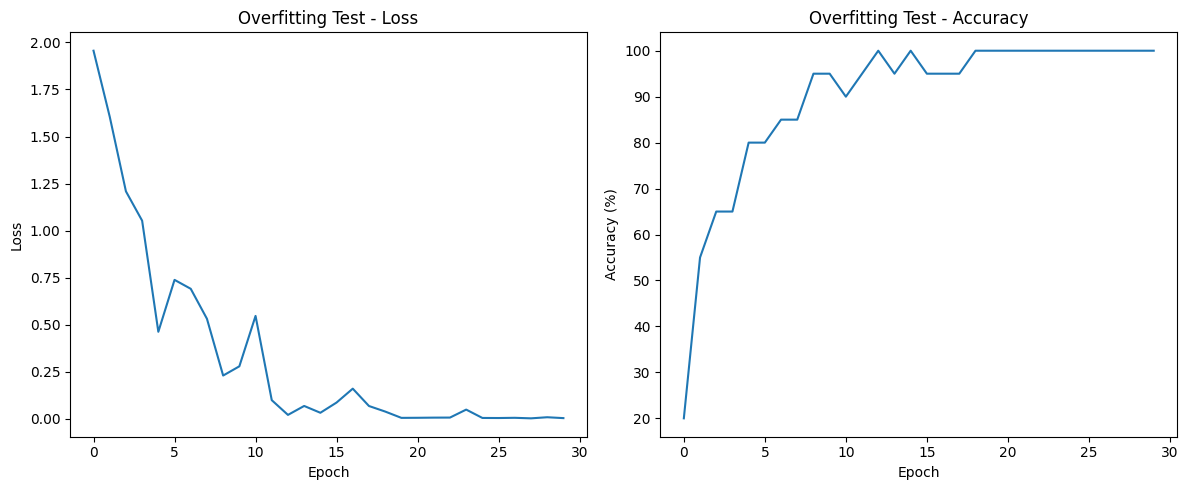

In [26]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(overfit_losses)
plt.title('Overfitting Test - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(overfit_accs)
plt.title('Overfitting Test - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.savefig('overfit_test.png')
plt.show()

wandb.log({"overfit_test": wandb.Image('overfit_test.png')})

In [27]:
if max(overfit_accs) > 95:
    print("Model passed the overfitting test! Proceeding with full training.")
else:
    print("Warning: Model may have issues with gradient flow as it didn't achieve high accuracy on the small dataset.")


Model passed the overfitting test! Proceeding with full training.


In [28]:
model = SimplerCNN(dropout_rate=wandb.config.dropout_rate).to(device)
optimizer = optim.Adam(
    model.parameters(),
    lr=wandb.config.learning_rate,
    weight_decay=wandb.config.weight_decay
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

# Full training loop
num_epochs = wandb.config.epochs
best_val_acc = 0
best_model_path = 'best_model.pth'

In [29]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100 * correct / total
        })

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation phase
    val_acc, _, _ = compute_accuracy(val_loader, model, device)
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc,
        "learning_rate": optimizer.param_groups[0]['lr']
    })

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with validation accuracy: {val_acc:.2f}%")


Epoch 1/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 1.7773, Train Acc: 26.99%, Val Loss: 1.5900, Val Acc: 34.95%
New best model saved with validation accuracy: 34.95%


Epoch 2/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 1.6113, Train Acc: 34.77%, Val Loss: 1.4819, Val Acc: 44.35%
New best model saved with validation accuracy: 44.35%


Epoch 3/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 1.5456, Train Acc: 38.69%, Val Loss: 1.4989, Val Acc: 44.81%
New best model saved with validation accuracy: 44.81%


Epoch 4/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 1.4942, Train Acc: 39.80%, Val Loss: 1.4067, Val Acc: 44.91%
New best model saved with validation accuracy: 44.91%


Epoch 5/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 1.4658, Train Acc: 40.87%, Val Loss: 1.3887, Val Acc: 46.30%
New best model saved with validation accuracy: 46.30%


Epoch 6/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 1.4404, Train Acc: 42.37%, Val Loss: 1.3868, Val Acc: 46.61%
New best model saved with validation accuracy: 46.61%


Epoch 7/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 1.4047, Train Acc: 43.98%, Val Loss: 1.3434, Val Acc: 48.14%
New best model saved with validation accuracy: 48.14%


Epoch 8/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 1.3785, Train Acc: 44.68%, Val Loss: 1.3355, Val Acc: 47.99%


Epoch 9/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 1.3514, Train Acc: 45.70%, Val Loss: 1.3387, Val Acc: 48.51%
New best model saved with validation accuracy: 48.51%


Epoch 10/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 1.3228, Train Acc: 46.58%, Val Loss: 1.3721, Val Acc: 47.14%


Epoch 11/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 1.2981, Train Acc: 47.37%, Val Loss: 1.3610, Val Acc: 47.93%


Epoch 12/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 1.2753, Train Acc: 48.03%, Val Loss: 1.3391, Val Acc: 49.42%
New best model saved with validation accuracy: 49.42%


Epoch 13/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 1.2078, Train Acc: 50.37%, Val Loss: 1.3137, Val Acc: 49.81%
New best model saved with validation accuracy: 49.81%


Epoch 14/20:   0%|          | 0/646 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c18a4dc1ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7c18a4dc1ee0>self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():  
  ^^^^^   ^  ^ ^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^
   File "/usr/lib/pytho

Epoch 14/20, Train Loss: 1.1806, Train Acc: 51.52%, Val Loss: 1.3304, Val Acc: 50.41%
New best model saved with validation accuracy: 50.41%


Epoch 15/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 1.1530, Train Acc: 53.24%, Val Loss: 1.3545, Val Acc: 51.57%
New best model saved with validation accuracy: 51.57%


Epoch 16/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 1.1178, Train Acc: 55.14%, Val Loss: 1.3190, Val Acc: 52.24%
New best model saved with validation accuracy: 52.24%


Epoch 17/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 1.0781, Train Acc: 56.88%, Val Loss: 1.3218, Val Acc: 53.31%
New best model saved with validation accuracy: 53.31%


Epoch 18/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 1.0235, Train Acc: 58.79%, Val Loss: 1.3228, Val Acc: 53.70%
New best model saved with validation accuracy: 53.70%


Epoch 19/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 0.9983, Train Acc: 59.83%, Val Loss: 1.3236, Val Acc: 52.84%


Epoch 20/20:   0%|          | 0/646 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.9673, Train Acc: 60.90%, Val Loss: 1.3468, Val Acc: 53.93%
New best model saved with validation accuracy: 53.93%


In [30]:
model.load_state_dict(torch.load(best_model_path))
wandb.save(best_model_path)

['/content/wandb/run-20250525_115427-5jutry1a/files/best_model.pth']

In [31]:
test_acc, test_preds, test_labels = compute_accuracy(test_loader, model, device)
print(f"Test Accuracy: {test_acc:.2f}%")
wandb.log({"test_accuracy": test_acc})

Test Accuracy: 54.37%


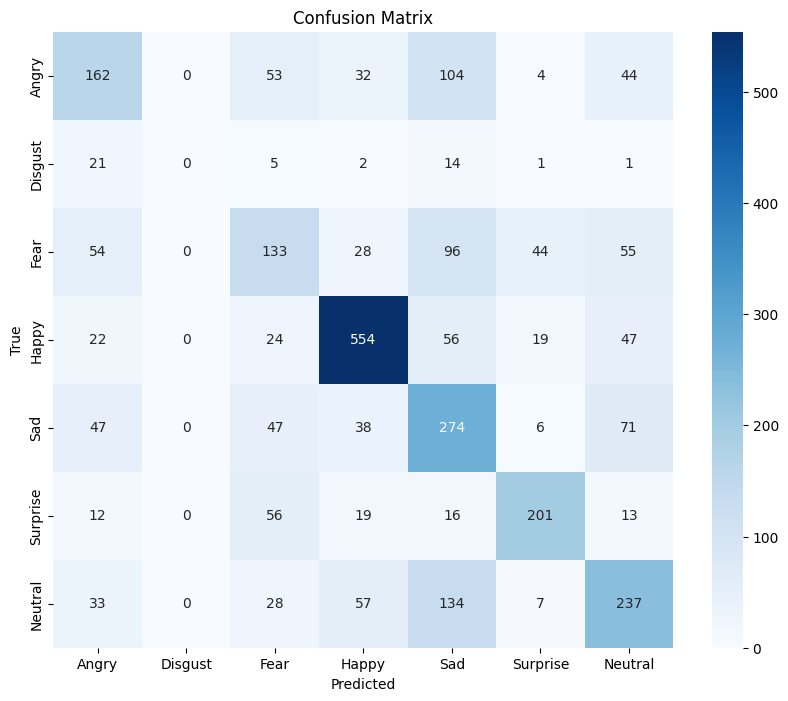

In [32]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(emotion_labels.values()),
            yticklabels=list(emotion_labels.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Log confusion matrix to wandb
wandb.log({"confusion_matrix": wandb.Image('confusion_matrix.png')})


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       Angry       0.46      0.41      0.43       399
     Disgust       0.00      0.00      0.00        44
        Fear       0.38      0.32      0.35       410
       Happy       0.76      0.77      0.76       722
         Sad       0.39      0.57      0.47       483
    Surprise       0.71      0.63      0.67       317
     Neutral       0.51      0.48      0.49       496

    accuracy                           0.54      2871
   macro avg       0.46      0.45      0.45      2871
weighted avg       0.54      0.54      0.54      2871



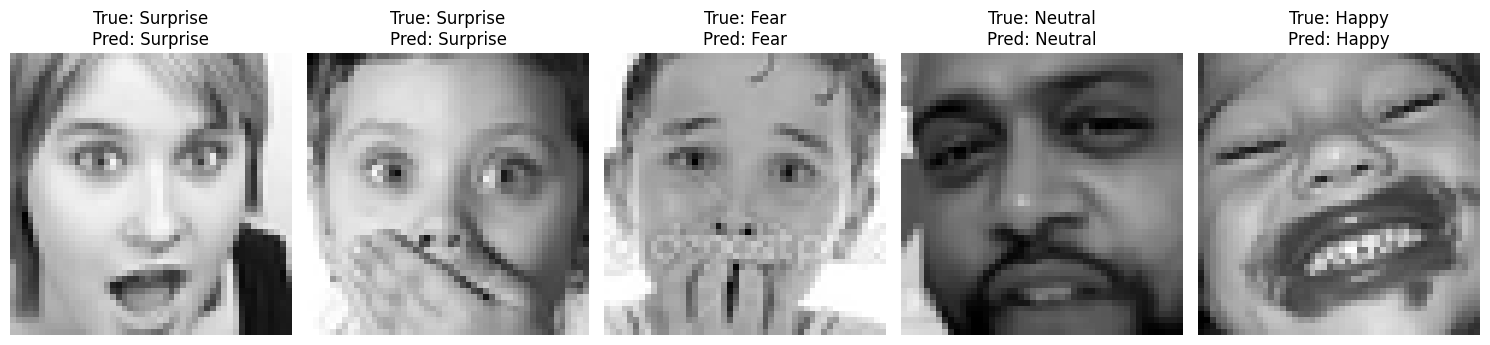

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,███████████▃▃▃▃▃▁▁▁▁
test_accuracy,▁
train_accuracy,▁▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇███
train_loss,█▇▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▁▁▁
val_accuracy,▁▄▅▅▅▅▆▆▆▅▆▆▆▇▇▇████
val_loss,█▅▆▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▂
epoch,20
learning_rate,0.00025
test_accuracy,54.3713
train_accuracy,60.89985


In [33]:

# Classification report
report = classification_report(test_labels, test_preds,
                               target_names=list(emotion_labels.values()))
print(report)

# Visualize sample predictions
plt.figure(figsize=(15, 10))
test_samples = 5
for i in range(test_samples):
    # Get random test image
    idx = np.random.randint(0, len(test_dataset))
    img, label = test_dataset[idx]

    # Make prediction
    img_tensor = img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)

    # Display image with true and predicted labels
    plt.subplot(1, test_samples, i+1)
    plt.imshow(img.squeeze().cpu().numpy(), cmap='gray')
    plt.title(f"True: {emotion_labels[label]}\nPred: {emotion_labels[predicted.item()]}")
    plt.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png')
plt.show()

wandb.log({"sample_predictions": wandb.Image('sample_predictions.png')})

# Finish the wandb run
wandb.finish()